# Gap Analysis Step 1b: Estimate the AEP and Its Uncertainty Using Cubico Open Data

<div class="alert alert-block alert-info">
Before getting started, be sure that the <code>reanalysis</code> modifier was used for installing OpenOA (i.e., <code>pip install "openoa[reanalysis]"</code>).
</div>

This notebook provides an overview and walk-through of the steps taken to produce a plant-level operational energy asssessment (OA) of a wind plant, using the open data available for [Kelmarsh](https://doi.org/10.5281/zenodo.5841833) and [Penmanshiel](https://doi.org/10.5281/zenodo.5946807).

Uncertainty in the annual energy production (AEP) estimate is calculated through a Monte Carlo approach. Specifically, inputs into the OA code as well as intermediate calculations are randomly sampled based on their specified or calculated uncertainties. By performing the OA assessment thousands of times under different combinations of the random sampling, a distribution of AEP values results from which uncertainty can be deduced. Details on the Monte Carlo approach will be provided throughout this notebook.

**Note**: If the data is not already available on your computer, be sure to install the additionally required packages `cdsapi` (ERA5 API library) and `xarray` (data handling for NetCDF data). This can be done via `pip install "openoa[weather]"` to have have it managed through the OpenOA installation process.

## Step 1: Import the data

Data is downloaded automatically from Zenodo for the wind farm data and from GES DISC and CDS for the long-term reanalysis data. These are then stored in the 'examples/data' folder under the asset names. Note this includes all available data, and so for the 2 assets uses about 20 GB of space in total. The first time this notebook is run it could therefore take a signficant amount of time to download the data (e.g. over an hour). Its recommended that you leave it to run, then restart and run-all to clear the download messages. For downloading the GES DISC and CDS long-term reanalysis data registration is also required, see: [GES DISC registration](https://disc.gsfc.nasa.gov/data-access#python-requests) and [CDS registration](https://cds.climate.copernicus.eu/api-how-to).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from openoa.analysis.aep import MonteCarloAEP
from openoa.utils import plot

import project_Elexon
import project_Cubico

In [2]:
%load_ext autoreload
%autoreload 2

In the call below, data is loaded using the `project_Cubico.prepare()` function.

In [3]:
assets = project_Elexon.get_Elexon_plant_information()

assets = assets.sort_values("name").set_index("dictionary_id")

assets

,gppd_idnr,esail_id,name,sett_bmu_id,ngc_bmu_id,4c_offshore_id,windpowernet_id,wikidata_id,wikipedia_id,power_technology_id,...,eic_id,cfd_id,jrc_id,iaea_id,old_repd_id,new_repd_id,crown_estate_id,longitude,latitude,fuel_type
dictionary_id,,,,,,,,,,,,,,,,,,,,,
10147,GBR0004331,ACHRW,AChruach Wind Farm,T_ACHRW-1,[ACHRW-1],NaN,NaN,NaN,NaN,NaN,...,48W00000ACHRW-1O,NaN,NaN,NaN,NaN,NaN,NaN,-5.393722,56.342860,WIND
10294,NaN,NaN,Aberdeen Bay,T_ABRBO-1,[ABRBO-1],aberdeen-(eowdc)-united-kingdom-uk47,windfarm_en_16769_eowdc,Q17509465,European_Offshore_Wind_Deployment_Centre,european-offshore-wind-deployment-centre-aberdeen,...,48W00000ABRBO-19,NaN,NaN,NaN,A0440,2505,ABRDB,-1.972800,57.222600,WIND
10288,NaN,NaN,Achlachan,C__PSMAR001,[ACHLW-1],NaN,NaN,NaN,NaN,NaN,...,NaN,AAA-ACH-183,NaN,NaN,C1202,4330,NaN,-3.456500,58.447900,WIND
10295,NaN,NaN,Afton,T_AFTOW-1,[AFTOW-1],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,N00302W,4262,NaN,-4.169100,55.312800,WIND
10148,GBR0004332,AKGLW,Aikengall 2 Wind Farm Generation,"T_AKGLW-2, T_AKGLW-3","[AKGLW-2, AKGLW-3]",NaN,NaN,NaN,NaN,NaN,...,48W00000AKGLW-22,NaN,NaN,NaN,NaN,7015,NaN,-2.492993,55.923317,WIND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10250,GBR0002519,WDNS,West of Duddon Sands,"T_WDNSO-1, T_WDNSO-2, T_WDNSW-1, T_WDNSW-2","[WDNSO-1, WDNSO-2, WDNSW-1, WDNSW-2]",west-of-duddon-sands-united-kingdom-uk33,windfarm_en_7396_west-of-duddon-sands,Q7987061,West_of_Duddon_Sands_Wind_Farm,west-of-duddon-sands-offshore-wind-farm,...,"48W00000WDNSO-1H, 48W00000WDNSO-2F",NaN,NaN,NaN,N00449W,2519,WDNSW,-3.768311,53.923751,WIND
10248,GBR0002545,WTMSO,Westermost Rough Windfarm,"T_WTMSO-1, T_WTMSD-1","[WTMSO-1, WTMSD-1]",westermost-rough-united-kingdom-uk34,windfarm_en_21826_westermost-rough,Q7987427,Westermost_Rough_Wind_Farm,westermost-rough-offshore-wind-farm-yorkshire,...,48W00000WTMSO-1M,NaN,NaN,NaN,N00556W,2545,WTMSO-1,0.681152,53.943155,WIND
10252,"GBR0003489, GBR0003981",WHILW,Whitelee Wind Farm,"T_WHILW-1, T_WHILW-2","[WHILW-1, WHILW-2]",NaN,NaN,NaN,NaN,NaN,...,"48W00000WHILW-1M, 48W00000WHILW-2K",NaN,NaN,NaN,N00055W,3489,NaN,-4.042969,55.702355,WIND


In [4]:
asset_dictionary_id =  10177 # 10181 10183 10185 10186 10199 10201 10214 10232 10234 10235 10242 10246
# 10163
asset = assets.loc[asset_dictionary_id]["name"]

asset

'Clyde Central Windfarm, Clyde North Windfarm, Clyde South Windfarm'

In [5]:
for cnt,asset_dictionary_id in enumerate(assets.index):

    asset = (assets.loc[asset_dictionary_id]["name"]).replace("/","")
    print(f"{cnt} {asset}")

0 AChruach Wind Farm
1 Aberdeen Bay
2 Achlachan
3 Afton
4 Aikengall 2 Wind Farm Generation
5 Airies Windfarm
6 An Suidhe Windfarm
7 Andershaw Wind Farm
8 Arecleoch Windfarm
9 Assel Valley Wind Farm
10 Auchrobert Wind Farm
11 Bad a Cheo
12 Baillie Wind Farm
13 Barrow Offshore Windfarm
14 Beatrice
15 Beinn An Tuirc 2 Windfarm
16 Beinn Tharsuinn
17 Beinneun Wind Farm
18 Berry Burn Windfarm
19 Bhlaraidh Windfarm 1
20 Black Law Wind Farm
21 Blackcraig Windfarm
22 Braes of Doune
23 Brockloch Rig 2 Windfarm
24 Burbo Bank Offshore Windfarm
25 Burn of Whilk Windfarm
26 Cairn Uish  Rothes Windfarm Extension
27 Camster Wind Farm
28 Carraig Gheal Wind Farm
29 Clachan Flats Windfarm
30 Clashindarroch Wind Farm
31 Clyde Central Windfarm, Clyde North Windfarm, Clyde South Windfarm
32 Coire Na Cloiche
33 Corriegarth Wind Farm
34 Corriemoillie Wind Farm
35 Cour Wind Farm
36 Crossdykes
37 Crystal Rig Wind Farm
38 Dalswinton Wind Farm
39 Dersalloch Windfarm
40 Dorenell
41 Dudgeon Offshore Wind Farm Gener

In [12]:
path = f"data/elexon/101437"

In [10]:
from pathlib import Path

In [30]:
for asset_dictionary_id in assets.index:

    asset = (assets.loc[asset_dictionary_id]["name"]).replace("/","")
    
    path = f"data/elexon/{asset_dictionary_id}/result_{asset}.csv"

    print(f"{path} {Path(path).exists()}")

data/elexon/10147/result_AChruach Wind Farm.csv True
data/elexon/10294/result_Aberdeen Bay.csv True
data/elexon/10288/result_Achlachan.csv True
data/elexon/10295/result_Afton.csv True
data/elexon/10148/result_Aikengall 2 Wind Farm Generation.csv True
data/elexon/10149/result_Airies Windfarm.csv True
data/elexon/10151/result_An Suidhe Windfarm.csv True
data/elexon/10150/result_Andershaw Wind Farm.csv True
data/elexon/10152/result_Arecleoch Windfarm.csv True
data/elexon/10153/result_Assel Valley Wind Farm.csv True
data/elexon/10154/result_Auchrobert Wind Farm.csv True
data/elexon/10296/result_Bad a Cheo.csv True
data/elexon/10155/result_Baillie Wind Farm.csv True
data/elexon/10156/result_Barrow Offshore Windfarm.csv True
data/elexon/10297/result_Beatrice.csv True
data/elexon/10157/result_Beinn An Tuirc 2 Windfarm.csv True
data/elexon/10159/result_Beinn Tharsuinn.csv True
data/elexon/10158/result_Beinneun Wind Farm.csv True
data/elexon/10160/result_Berry Burn Windfarm.csv True
data/elexon

In [32]:
results = []

for asset_dictionary_id in assets.index:

    asset = (assets.loc[asset_dictionary_id]["name"]).replace("/","")
    
    file_path = f"data/elexon/{asset_dictionary_id}/result_{asset}.csv"

    if not Path(file_path).exists():

        try:
            project = project_Elexon.prepare(dictionary_id=asset_dictionary_id)

            pa = MonteCarloAEP(project, reanalysis_products = list(project.reanalysis.keys()))

            print(f"{asset}: {pa.aggregate.index[0]} to {pa.aggregate.index[-1]}")

            # Run Monte Carlo based OA
            pa.run(num_sim=10000, reanalysis_products="era5_monthly", outlier_detection=True, operational_months_min=6,operational_months_max=700)

            # Produce histograms of the various MC-parameters
            mc_reg = pd.DataFrame(data={
                'slope': pa._mc_slope.ravel(),
                'intercept': pa._mc_intercept, 
                'num_points': pa._mc_num_points, 
                'metered_energy_fraction': pa.mc_inputs.metered_energy_fraction, 
                'loss_fraction': pa.mc_inputs.loss_fraction,
                'num_years_windiness': pa.mc_inputs.num_years_windiness, 
                'loss_threshold': pa.mc_inputs.loss_threshold,
                'reanalysis_product': pa.mc_inputs.reanalysis_product,
                "operational_months":pa.mc_inputs.operational_months,
            })

            # Boxplot of AEP based on number of years in windiness correction
            # NOTE: This is the same method, but calling the same method through the plot module directly
            box_figure = plot.plot_boxplot(
                y=100*pa.results.aep_GWh/pa.results.aep_GWh.median(),
                x=mc_reg['operational_months'],
                xlabel="Operational months",
                ylabel="AEP percentage of median result (%)",
                plot_kwargs_box={"flierprops":dict(marker="x", markeredgecolor="tab:blue"),},
                figure_kwargs={"figsize":(24, 6)},
                ylim=[80,120],
                return_fig=True,
            )

            box_figure[0].savefig(f"C:/Users/Charlie/Pictures/WindEuropePoster/{asset}.png")

            result = pd.concat([mc_reg,pa.results.aep_GWh],axis=1)

            result.to_csv(file_path)

        except:
            print(f"#####################")
            print(f"#####################")
            print(f"{asset} failed to run")
            print(f"#####################")
            print(f"#####################")

    else:

        result = pd.read_csv(file_path)
    
    results.append(result)

  return self._transformer._transform_point(

  return self._transformer._transform_point(



East Anglia: 2019-08-01 00:00:00 to 2024-02-01 00:00:00


  0%|          | 42/10000 [00:00<01:18, 126.14it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
aep_trends = []

for result in results:
    aep_trends.append(result[["operational_months","aep_GWh"]].groupby("operational_months").median()/result["aep_GWh"].median())

aep_trend = pd.concat(aep_trends,axis=1)

<Axes: xlabel='operational_months'>

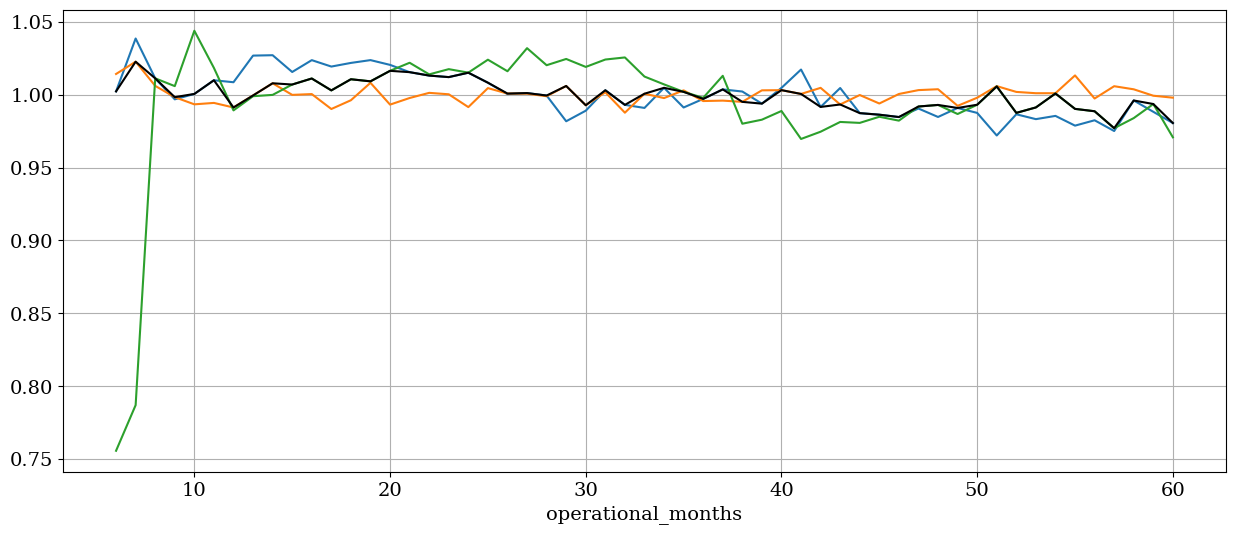

In [ ]:
aep_trend.plot(legend=False)
aep_trend.median(axis=1).plot(c="black")